In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [4]:
import sys    
path_to_module = '/content/drive/MyDrive/HW3/code'
sys.path.append(path_to_module)

image shape: (410, 615, 3)


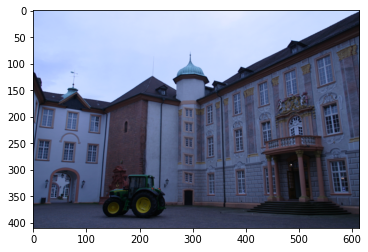

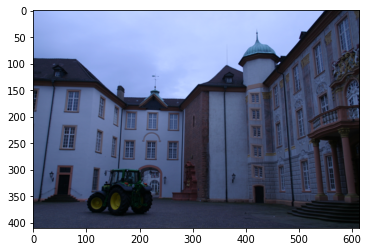

In [5]:
# load the images
im_left = cv2.imread('/content/drive/MyDrive/HW3/data/0014_2.png')
print("image shape:", im_left.shape)
plt.imshow(im_left[:, :, ::-1])
plt.figure()
im_right = cv2.imread('/content/drive/MyDrive/HW3/data/0017_2.png')
plt.imshow(im_right[:, :, ::-1])
images = [im_left, im_right]

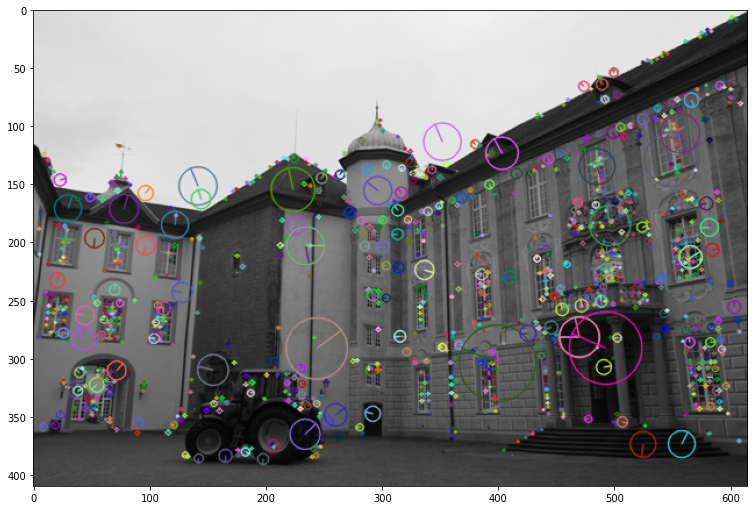

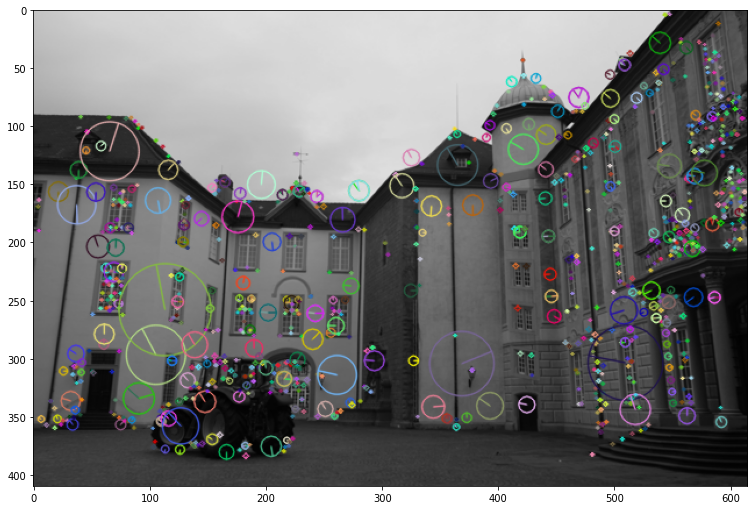

In [7]:
""" Detects SIFT features in all of the images
"""
keypoints = []
descriptions = []
for im in images:
  gray= cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  kp, des = sift.detectAndCompute(gray,None)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray,kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

  plt.imshow(out_im)

num matches 393


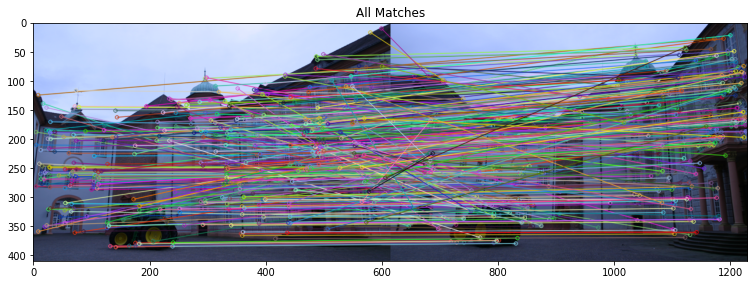

In [8]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(descriptions[0], descriptions[1])

print("num matches", len(matches))


matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("All Matches")
plt.imshow(matched_image)


In [9]:
""" Compute calibrated coordinates
"""

# For the satsok castle images
f1 = f2 = 552
u0 = 307.5
v0 = 205

K = np.array([[f1, 0, u0],
              [0, f2, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T
uncalibrated_2 = np.array(uncalibrated_2).T

k_inv = np.linalg.inv(K)

calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T


In [10]:
from lse import least_squares_estimation

E_least = least_squares_estimation(calibrated_1, calibrated_2)
print("E least", E_least)

E least [[ 0.03483464  0.19532636  0.00230723]
 [ 0.12138735  0.96929545 -0.08251168]
 [-0.4816593  -0.00994682 -0.87604651]]


(188,)
E_ransac [[-0.00240025 -0.07852295  0.02252064]
 [ 0.52963389  0.01934081 -0.84772158]
 [-0.11732375  0.98877012 -0.0487032 ]]
Num inliers (188,)


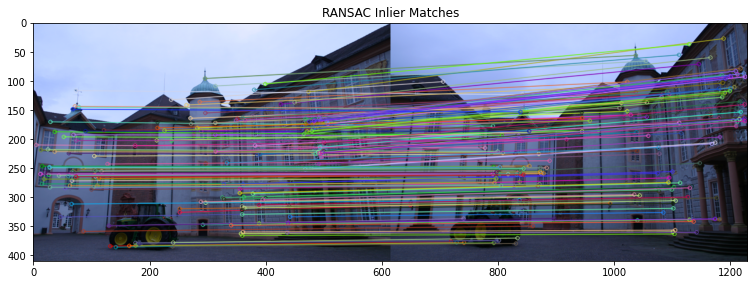

In [11]:
from ransac import ransac_estimator

# running this cell will take a while!!!

E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
print("E_ransac", E_ransac)
print("Num inliers", inliers.shape)

inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

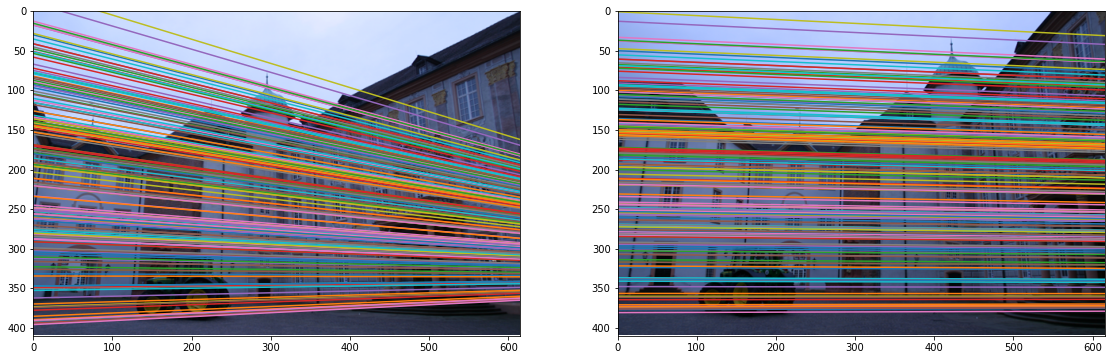

In [12]:
from plot_epi import plot_epipolar_lines

uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T

plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [13]:
from pose import pose_candidates_from_E

transform_candidates = pose_candidates_from_E(E_ransac)
print("transform_candidates", transform_candidates)
for c in transform_candidates:
  print(np.linalg.det(c['R']))

np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]).T

transform_candidates [{'T': array([0.99665501, 0.02195462, 0.07871969]), 'R': array([[ 0.79299139,  0.14543831,  0.59161842],
       [ 0.13518577, -0.98888489,  0.06189902],
       [ 0.594045  ,  0.03089301, -0.80383839]])}, {'T': array([0.99665501, 0.02195462, 0.07871969]), 'R': array([[ 0.88152822,  0.10506717,  0.46029218],
       [-0.09829894,  0.9944031 , -0.03872721],
       [-0.46178493, -0.01110711,  0.88692238]])}, {'T': array([-0.99665501, -0.02195462, -0.07871969]), 'R': array([[ 0.79299139,  0.14543831,  0.59161842],
       [ 0.13518577, -0.98888489,  0.06189902],
       [ 0.594045  ,  0.03089301, -0.80383839]])}, {'T': array([-0.99665501, -0.02195462, -0.07871969]), 'R': array([[ 0.88152822,  0.10506717,  0.46029218],
       [-0.09829894,  0.9944031 , -0.03872721],
       [-0.46178493, -0.01110711,  0.88692238]])}]
1.0000000000000004
1.0000000000000007
1.0000000000000004
1.0000000000000007


array([[ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  0,  1]])

In [14]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

best 0 (393,)
best 225 (393,)
not best 1
not best 168


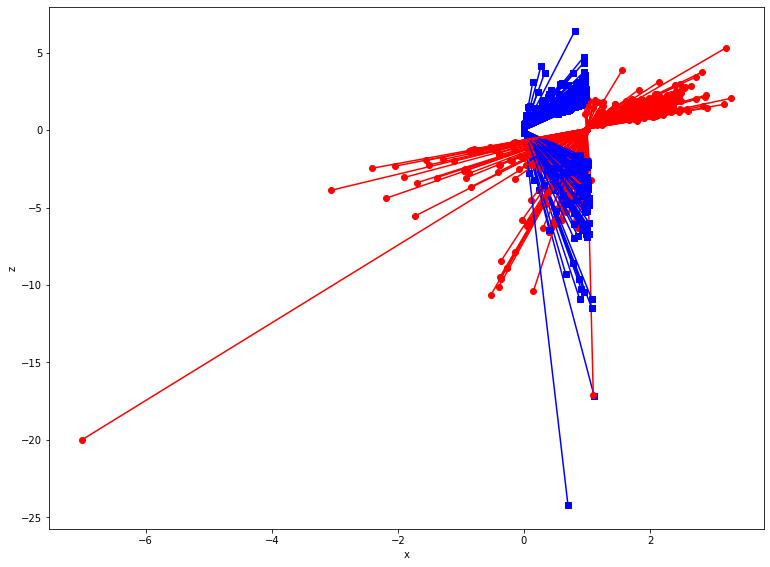

In [15]:
from recon3d import reconstruct3D 

P1, P2, T, R = reconstruct3D(transform_candidates, calibrated_1, calibrated_2)

plot_reconstruction(P1, P2, T, R)

1.0000000000000007


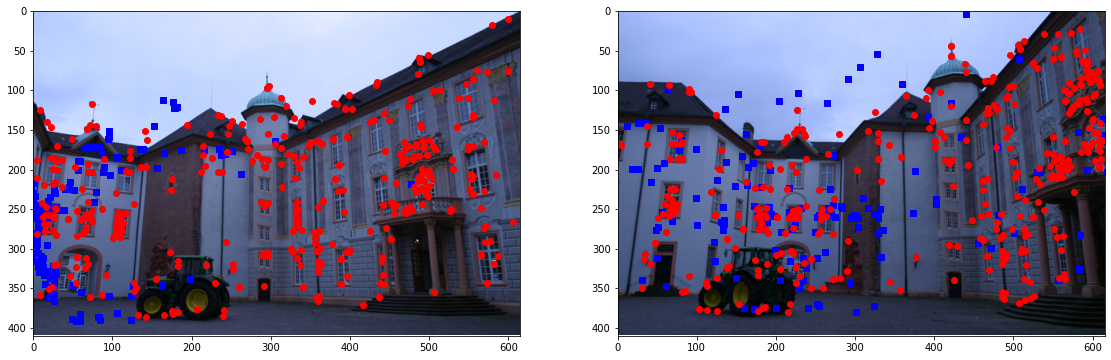

In [16]:
from show_reproj import show_reprojections

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)